# Kernel Ridge Regression

In this notebook, we'll do a quick demonstration of kernel ridge regression.

In [1]:
import sys
sys.path.append("../../")

import objax
import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
from jax.config import config
config.update("jax_enable_x64", False)

# dependence measures
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF, HSICRBFSampler, CKARBFSampler
from jaxkern.kernels.linear import linear_kernel
from jaxkern.kernels.stationary import rbf_kernel
from jaxkern.kernels.utils import kernel_matrix
from jaxkern.kernels.sigma import estimate_sigma_median

# preprocessing
import tqdm
from sklearn.preprocessing import StandardScaler

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Toy Data

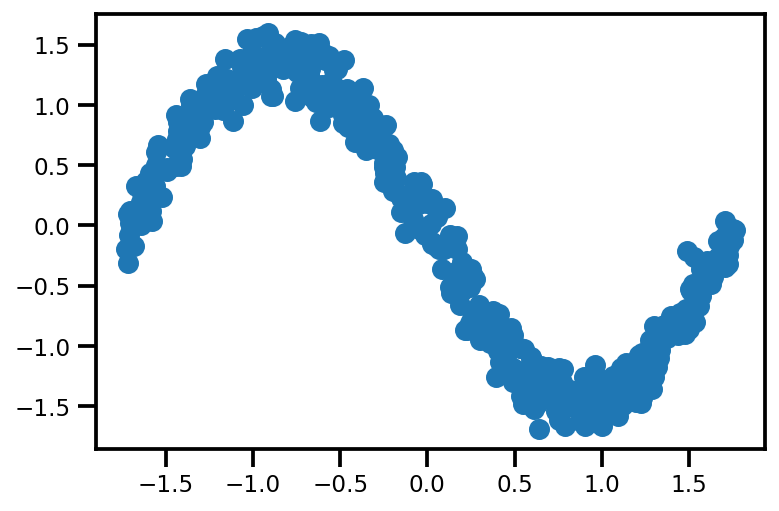

In [2]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
n_features = 1
noise_y = 0.1

X = 2.*np.pi * rng.rand(n_samples, n_features)
Y = np.sin(X) + noise_y * rng.randn(n_samples, n_features)

X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

### Kernel Ridge Regression

#### Exact solution





### Model

In [3]:
# kernel function
params = {"length_scale": 0.1}
variance = 1.0
noise_level = 0.01 

kernel = jax.partial(kernel_matrix, jax.partial(rbf_kernel, params['length_scale'], variance))

# data kernel
K = kernel(X, X)

# krr kernel
K_krr = K + noise_level * np.eye(K.shape[0])

### Exact Solution

$$
\alpha = (\mathbf{K} + \lambda \mathbf{I}_N)^{-1}\mathbf{y}
$$


In [4]:
weights = np.linalg.inv(K_krr) @ Y

### Predictions

$$
\hat{y} = k(\mathbf{X}, \mathbf{x})^\top \alpha
$$

In [5]:
yhat = kernel(X, X).T @ weights

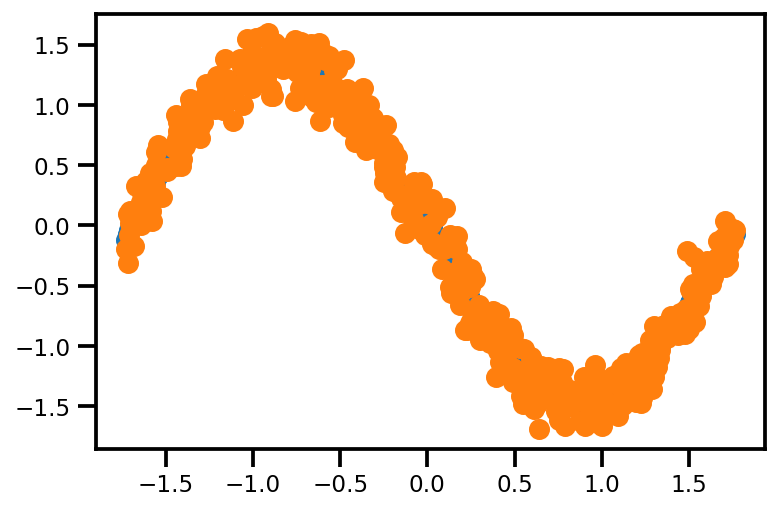

In [6]:
plt.scatter(X, yhat)
plt.scatter(X, Y)

In [7]:
import objax

class KRR(objax.Module):
    def __init__(self, variance, length_scale, noise, X, Y):
        
        self.X_ = X
        self.Y_ = Y
        self.variance = variance
        self.length_scale = objax.TrainVar(np.array([length_scale]))
        self.noise = noise
        
    
    def __call__(self, X):
        
        # kernel matrix
        self.kernel = jax.partial(
            kernel_matrix, 
            jax.partial(rbf_kernel, 
                        jax.nn.softplus(self.length_scale.value), self.variance)
        )
        K = self.kernel(self.X_, X)
        
        self.K_krr = K + self.noise * np.eye(K.shape[0])
        
        self.weights = np.linalg.inv(self.K_krr) @ self.Y_
        
        return K.T @ self.weights
    
    def get_factorizations(self):
        
        # kernel matrix
        self.kernel = jax.partial(
            kernel_matrix, 
            jax.partial(rbf_kernel, 
                        jax.nn.softplus(self.length_scale.value), self.variance)
        )
        K = self.kernel(self.X_, self.X_)
        
        self.K_krr = K + self.noise * np.eye(K.shape[0])
        
        self.weights = np.linalg.inv(self.K_krr) @ self.Y_
        return self
    
    def predict(self, X):
        return self.kernel(X, self.X_) @ self.weights

In [8]:
%%time
krr_model = KRR(1.0, 1.1, 1.0, X, Y)

yhat = krr_model(X)

CPU times: user 113 ms, sys: 5.35 ms, total: 119 ms
Wall time: 104 ms


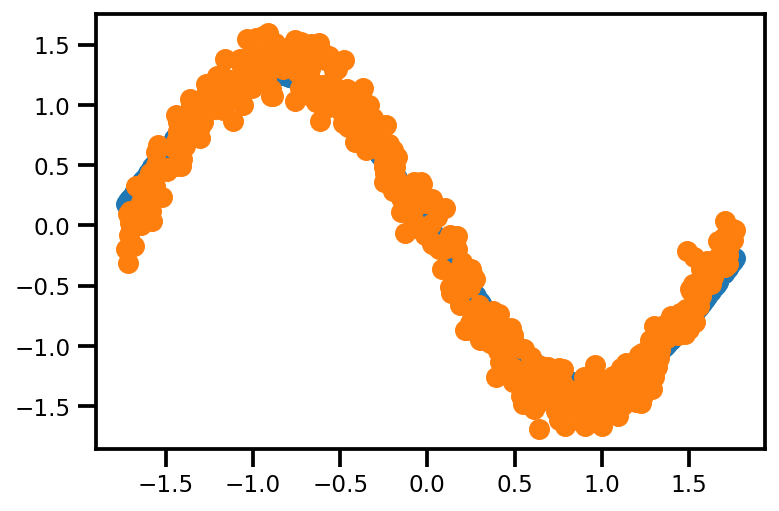

In [9]:
plt.scatter(X, yhat)
plt.scatter(X, Y)

#### Loss Function

$$
\mathcal{L}(\theta) = ||y - \mathbf{K}\alpha||_2^2 + \lambda \alpha^\top \mathbf{K}\alpha
$$

where:

* $\mathbf{K}\in \mathbb{R}^{N \times N}$
* $\alpha \in \mathbb{R}^{N \times 1}$
* $\mathbf{y} \in \mathbb{R}^{N \times P}$

In [10]:
def loss(model, X, Y):
    y_pred = model(X)
    norm_loss = np.linalg.norm(Y - y_pred, ord=2)**2
    reg_loss = model.noise * model.weights.T @ model.K_krr @ model.weights 
    return np.squeeze(norm_loss + reg_loss)

In [11]:
loss(krr_model, X, Y)

DeviceArray(57.559917, dtype=float32)

#### Optimization

In [12]:
opt = objax.optimizer.Adam(krr_model.vars())

#### Training Loop

In [13]:
loss_f = jax.partial(loss, krr_model)
gv = objax.GradValues(loss_f, krr_model.vars())
lr = 0.1

def train_op(x, label):
    g, v = gv(x, label)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
# train_op = objax.Jit(train_op, gv.vars() + opt.vars())

In [14]:
g, v = gv(X, Y)

In [15]:
n_epochs = 100
losses = []

pbar = tqdm.trange(n_epochs)

for _ in pbar:

    # Train
    loss = train_op(X, Y)

    losses.append(loss)

    # update progress bar
    postfix = dict(Loss=f"{loss[0]:.2f}")
    pbar.set_postfix(postfix)


100%|██████████| 100/100 [00:04<00:00, 22.44it/s, Loss=24.73]


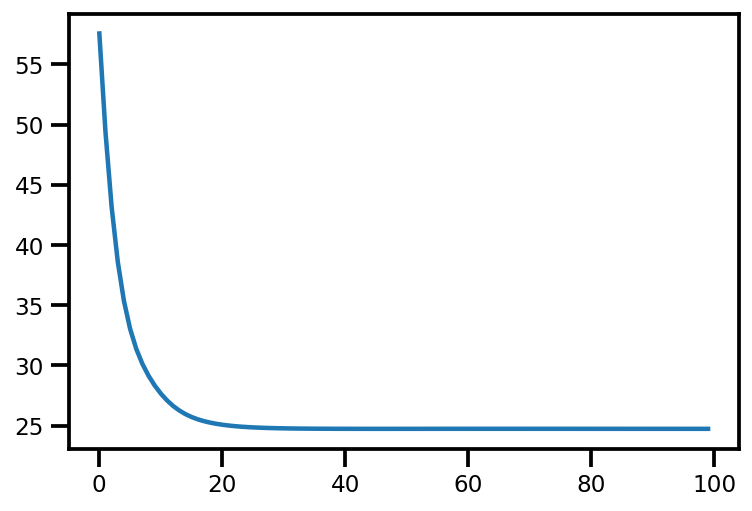

In [16]:
plt.plot(losses)

In [17]:
for ikey, val in krr_model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(KRR).length_scale [-0.61202186] [0.4332446] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [18]:
krr_model.get_factorizations()
type(krr_model.weights)

jax.interpreters.xla.DeviceArray

In [19]:
yhat = krr_model.predict(X)

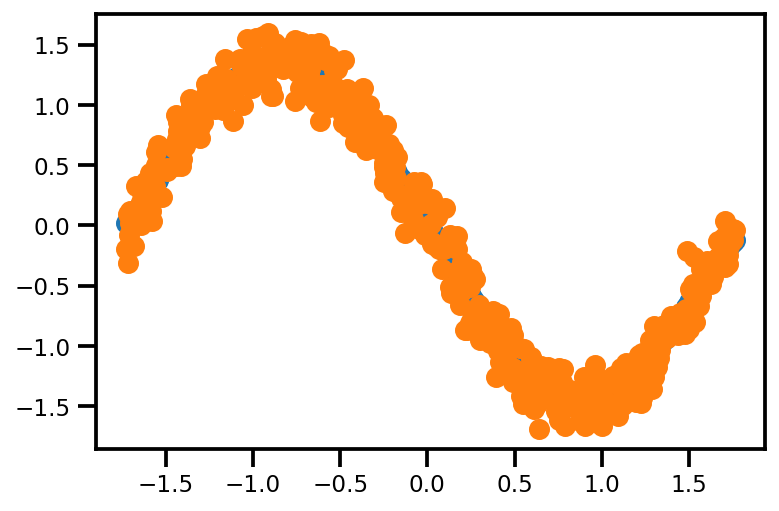

In [20]:
plt.scatter(X.squeeze(), yhat.squeeze())
plt.scatter(X.squeeze(), Y.squeeze())